# Instrument Recognition con CNN

## Fase 1: Strumenti necessari

In [ ]:
pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=c167fc6395a2de0dde7f37d12ce82c8429ef9460a202d57b4471a59cd2b22cb4
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
import os
import numpy as np
import librosa
from librosa import feature
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

%matplotlib inline

In [ ]:
!nvidia-smi

Thu Jan 13 15:29:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Fase 2: Importazione del dataset

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
data = "/content/gdrive/MyDrive/Progetto_Principi/"

Mounted at /content/gdrive


In [ ]:
data_frame = pd.read_csv(data + 'train.csv')
data_frame.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


Essendo il numero di classi all'interno del dataset piuttosto alto (41), ne sceglieremo un numero minore tra quelle disponibili (5, ossia 'Cello',   'Saxophone', 'Acoustic_guitar', 'Double_bass', 'Clarinet'), scartando dunque il resto del dataset. Per fare questo:

In [ ]:
instruments = ['Cello','Saxophone','Acoustic_guitar','Double_bass', 'Clarinet']
data_frame = data_frame[data_frame['label'].isin(instruments)]

Il codice qui sopra non fa altro che prendere tutte le n-uple all'interno del dataset per cui il valore della colonna label è uno di quelli indicati all'interno della lista delle etichette che abbiamo deciso di selezionare. Con il codice qui sotto, invece, riusciamo a controllare come il numero di dati relativi alle classi (strumenti) che abbiamo selezionato sono piuttosto omogenei

In [ ]:
for i in instruments:
  print(i + ' --> ' + str(data_frame[data_frame['label'] == i].shape))

Cello --> (300, 3)
Saxophone --> (300, 3)
Acoustic_guitar --> (300, 3)
Double_bass --> (300, 3)
Clarinet --> (300, 3)


In [ ]:
audio_list = []
not_found = 0
for i in tqdm(range(data_frame.shape[0])):
  try:
    audio_list.append(librosa.load(data + 'audio/audio_train/' + data_frame['fname'].iloc[i]))
  except:
    not_found += 1
data_frame.head()

100%|██████████| 1500/1500 [18:57<00:00,  1.32it/s]


,fname,label,manually_verified
1,001ca53d.wav,Saxophone,1
4,00353774.wav,Cello,1
5,003b91e8.wav,Cello,0
8,004ad66f.wav,Clarinet,0
14,0091fc7f.wav,Cello,1


In [ ]:
audio_list = np.array(audio_list)
print(audio_list.shape)
print(data_frame.shape)

(1500, 2)
(1500, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


A questo punto, andiamo ad aggiungere le informazioni relative ai suoni (segnale e frequenza di campionamento) all'interno del data frame

In [ ]:
data_frame['audio_waves'] = audio_list[:,0]
data_frame['sample_rate'] = audio_list[:,1]
data_frame.head()

,fname,label,manually_verified,audio_waves,sample_rate
1,001ca53d.wav,Saxophone,1,"[-0.0007303721, -0.0010996412, -0.0010551845, ...",22050
4,00353774.wav,Cello,1,"[-0.003822653, -0.0053708917, -0.0044372473, -...",22050
5,003b91e8.wav,Cello,0,"[0.0031921505, 0.0048865937, 0.004513402, 0.00...",22050
8,004ad66f.wav,Clarinet,0,"[-0.00018609133, -0.00029739283, -0.0003075322...",22050
14,0091fc7f.wav,Cello,1,"[0.00042805163, 0.0005860274, 0.00045838652, 0...",22050


Tramite queste due informazioni, si calcolano altre caratteristiche dei segnali audio importati dal dataset, ossia il numero di bit che compongono il segnale e la lunghezza in termini di tempo, che torneranno utili successivamente. Anche in questo caso, si inseriscono i nuovi dati all'interno del data frame.

In [ ]:
bit_len = []
for aw in range(data_frame.shape[0]):
    bit_len.append(len(data_frame['audio_waves'].iloc[aw]))
bit_len = np.array(bit_len)
data_frame['bit_lengths'] = bit_len
data_frame['time_length'] = data_frame['bit_lengths']/data_frame['sample_rate']
data_frame.head()

,fname,label,manually_verified,audio_waves,sample_rate,bit_lengths,time_length
1,001ca53d.wav,Saxophone,1,"[-0.0007303721, -0.0010996412, -0.0010551845, ...",22050,227556,10.32
4,00353774.wav,Cello,1,"[-0.003822653, -0.0053708917, -0.0044372473, -...",22050,99666,4.52
5,003b91e8.wav,Cello,0,"[0.0031921505, 0.0048865937, 0.004513402, 0.00...",22050,292824,13.28
8,004ad66f.wav,Clarinet,0,"[-0.00018609133, -0.00029739283, -0.0003075322...",22050,154350,7
14,0091fc7f.wav,Cello,1,"[0.00042805163, 0.0005860274, 0.00045838652, 0...",22050,125685,5.7


## Fase 3: Manipolazione dei dati
A questo punto, si conoscono diverse informazioni relative ai segnali. Come si può notare dai dati collezionati fino ad ora, i valori di lunghezza (di bit e, dunque, in termini di tempo) sono diversi fra loro. Questo è un problema: la CNN non è in grado di adattarsi a segnali di diverse lunghezze; per questo motivo, è necessario rendere tutti i segnali all'interno del dataset lunghi uguali. Inoltre, bisogna tenere conto della lunghezza selezionata per i segnali: se la dimensione scelta fosse troppo grande, la fase di training diventerebbe troppo lunga; al contrario, una dimensione troppo ridotta non permetterebbe ai neuroni della rete di recuperare le informazioni necessarie per poter eseguire una classificazione precisa. Per questo motivo, la soluzione consigliata è quella di mantenere una lunghezza di 2 secondi.

Per prima cosa, è necessario eliminare tutti i segnali più brevi del tempo prestabilito.

In [ ]:
data_frame = data_frame[data_frame['time_length'] >= 2.0]

In [ ]:
for i in instruments:
  print(i + ' --> ' + str(data_frame[data_frame['label'] == i].shape))

Cello --> (286, 7)
Saxophone --> (250, 7)
Acoustic_guitar --> (275, 7)
Double_bass --> (205, 7)
Clarinet --> (290, 7)


In [ ]:
min_seconds = np.min(data_frame['time_length'])
print(min_seconds)

2.0


Il dato minimo di lunghezza in bit è un dato molto importante...

In [ ]:
min_bits = np.min(data_frame['bit_lengths'])
print(min_bits)

44100


... perchè permette di eseguire la seguente operazione definita qui sotto; il compito di questa funzione è quello di prendere un campione di 2 secondi da una traccia audio scelta casualmente all'interno del dataset (una traccia audio può essere utilizzata per la creazione di diversi campioni). Il valore minimo di bit (44100) è l'equivalente in termini di tempo di 2 secondi e verrà dunque utilizzato per spostarsi all'interno del segnale.

In [ ]:
num_samples = 6000
generated_audio_waves = []
generated_audio_labels = []
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(data_frame['fname'].values)
        first_bit = np.random.choice(np.arange(0, data_frame[data_frame['fname'] == chosen_file]['bit_lengths'].values - min_bits))
        generated_audio_waves.append(data_frame[data_frame['fname']==chosen_file]['audio_waves'].values[0][first_bit:first_bit + min_bits])
        generated_audio_labels.append(data_frame[data_frame['fname']==chosen_file]['label'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|██████████| 6000/6000 [00:10<00:00, 562.52it/s]


## Fase 4: Preprocessing del segnale audio: MFCC

Una volta recuperati i campioni da 2 secondi dalle tracce audio presenti nel dataset, i dati che si conoscono potrebbero essere sufficienti per passare alla fase di training e successivo testing della rete neurale. Il problema dei segnali audio che sono stati selezionati è che non sono altro che vettori lunghi 44100 bit (2 secondi in termini di tempo) che non hanno vere e proprie informazioni in grado di permettere ad una rete neurale di classificarle con accuratezza, poichè rappresentano solamente la potenza del segnale in ogni bit (più concretamente, quanto è forte un suono).<br>
La modalità adottata in questo studio (ma anche in molti altri algoritmi di sound recognition) è quella dell'estrazione del **MFCC** (*Mel-Frequency Cepstral Coefficient(s)*). Questi coefficienti sono definiti come una rappresentazione sulla *scala di Mel* (ossia una scala che mette in rapporto le frequenze in Hz con l'intensità dei suoni in dB) dello spettro di un segnale audio.
Il calcolo della MFCC, che segue processi matematici piuttosto complessi, viene eseguito dalla omonima funzione della libreria *python_speech_features* e crea un'immagine in cui il colore dei pixel varia in base all'intensità del segnale: all'aumentare dell'intensità, il colore diventa sempre più chiaro.<br>
La differenza fondamentale tra il segnale audio in forma "normale" e quello preprocessato (ossia MFCC) è che il secondo, oltre a tenere in considerazione la potenza del segnale, riesce anche a estrarre informazioni relative alla sua **intonazione**, permettendo dunque di classificare con maggiore precisione i vari campioni.  

Dunque, calcoliamo per ogni campione all'interno della lista *generated_audio_waves* i coefficienti di MFCC e li memorizziamo al'interno di una lista.

In [ ]:
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

100%|██████████| 5966/5966 [00:44<00:00, 132.80it/s]


Da notare la differenza tra le due strutture dati: la prima, contiene vettori lunghi 44100 bit, mentre la seconda contiene informazioni che permettono di creare una *heatmap* 275x13 dei medesimi campioni, dove: 
<ul>
    <li>275 è il rapporto tra la lunghezza del segnale (44100) e la frequenza di campionamento utilizzata dalla funzione <i>mfcc</i></li>
    <li>13 rappresenta i livelli di potenza del segnale</li>
</ul>

In [ ]:
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(5966, 44100)
(5966, 275, 13)


I seguenti plot raffigurano lo stesso segnale, prima rappresentato come potenza del segnale su ogni singolo bit del campione, mentre il secondo rappreseta la *heatmap* dei MFCC del segnale.

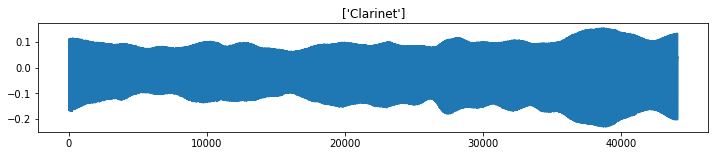

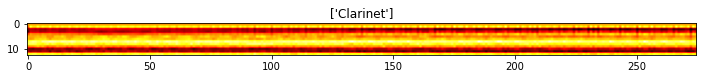

In [ ]:
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[30])
plt.title(generated_audio_labels[30])
plt.show()

plt.figure(figsize=(12,2))
plt.imshow(mfcc_features[30].T, cmap='hot') # .T ribalta il segnale (altrimenti lo vedreste verticale)
plt.title(generated_audio_labels[30])
plt.show()

## Fase 5: Codifica dei target/label
Dobbiamo codificare i label, che ora sono ancora stringhe, prima con un semplice labelEncoder e poi con un OneHotEncoder per esprimere la classe di appartenenza del segnale

In [ ]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
label_encoded = label_encoded[:, np.newaxis]
label_encoded

array([[2],
       [0],
       [3],
       ...,
       [0],
       [3],
       [2]])

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
print(pd.get_dummies(one_hot_encoded[0]))
print("---")
print(one_hot_encoded[0])

   0.0  1.0
0    1    0
1    1    0
2    0    1
3    1    0
4    1    0
---
[0. 0. 1. 0. 0.]


## Fase 6: Training del modello
A questo punto siamo pronti per la fase di training della CNN.<br>
Si normalizzano i campioni utilizzando la formula della normalizzazione standard; successivamente si dividono i campioni in train e test (il 20% del totale diventerà un campione di test).

In [ ]:
X = mfcc_features
y = one_hot_encoded
X = (X-X.min())/(X.max()-X.min())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.33)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(input_shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
print(X_val.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(275, 13, 1)
(4176, 275, 13, 1)
(1199, 275, 13, 1)
(591, 275, 13, 1)


Costruiamo il modello.

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['acc'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 275, 13, 16)       160       
                                                                 
 conv2d_15 (Conv2D)          (None, 275, 13, 32)       4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 137, 6, 32)       0         
 2D)                                                             
                                                                 
 dropout_21 (Dropout)        (None, 137, 6, 32)        0         
                                                                 
 flatten_7 (Flatten)         (None, 26304)             0         
                                                                 
 dense_21 (Dense)            (None, 128)               3367040   
                                                      

Ora è il momento di fare il fit del modello.

In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
131/131 [==============================] - 2s 10ms/step - loss: 1.4413 - acc: 0.3443 - val_loss: 1.2318 - val_acc: 0.4595
Epoch 2/30
131/131 [==============================] - 1s 8ms/step - loss: 1.2227 - acc: 0.4713 - val_loss: 1.0911 - val_acc: 0.5780
Epoch 3/30
131/131 [==============================] - 1s 8ms/step - loss: 1.1155 - acc: 0.5563 - val_loss: 0.9801 - val_acc: 0.6297
Epoch 4/30
131/131 [==============================] - 1s 8ms/step - loss: 1.0270 - acc: 0.6008 - val_loss: 0.8778 - val_acc: 0.6656
Epoch 5/30
131/131 [==============================] - 1s 8ms/step - loss: 0.9559 - acc: 0.6341 - val_loss: 0.8211 - val_acc: 0.6881
Epoch 6/30
131/131 [==============================] - 1s 8ms/step - loss: 0.8683 - acc: 0.6741 - val_loss: 0.7523 - val_acc: 0.7206
Epoch 7/30
131/131 [==============================] - 1s 8ms/step - loss: 0.8236 - acc: 0.6980 - val_loss: 0.7250 - val_acc: 0.7314
Epoch 8/30
131/131 [==============================] - 1s 8ms/step - loss: 0

loss: 0.3825635612010956
val_loss: 0.42111775279045105


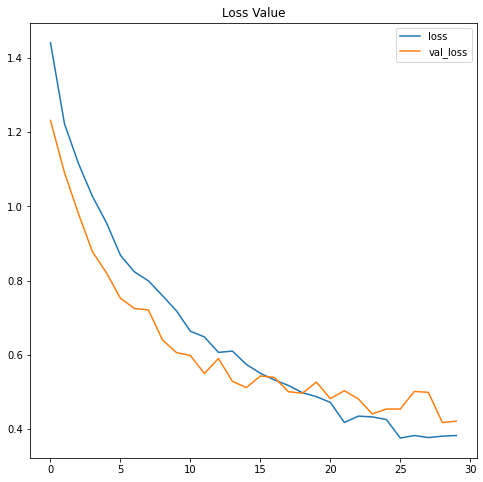

acc: 0.8620689511299133
val_acc: 0.847372829914093


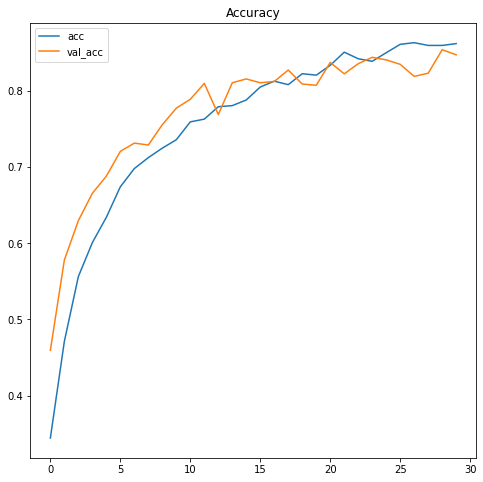

In [ ]:
plt.figure(figsize=(8,8))
plt.title("Loss Value")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
print("loss:", history.history["loss"][-1])
print("val_loss:", history.history["val_loss"][-1])
plt.show()
plt.figure(figsize=(8,8))
plt.title("Accuracy")
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["acc", "val_acc"])
print("acc:", history.history["acc"][-1])
print("val_acc:", history.history["val_acc"][-1])
plt.show()

## Fase 7: Valutazione della rete neurale
Al termine della fase di training si passa alla valutazione dell'efficacia della rete neurale

In [ ]:
predictions = model.predict(X_test)

In [ ]:
print(predictions[:3])
predictions = np.argmax(predictions, axis=1)
print(predictions[:3])
y_test = one_hot_encoder.inverse_transform(y_test)

[[5.5706030e-04 9.9931872e-01 4.9212958e-06 1.1780894e-04 1.5147926e-06]
 [7.9187714e-07 9.9999905e-01 7.1295858e-08 6.2149445e-11 1.1601230e-08]
 [4.7553036e-02 2.8247045e-02 4.7846137e-05 9.2414355e-01 8.6373711e-06]]
[1 1 3]


In [ ]:
print(predictions[:10])
print("---")
print(y_test[:10].T)

[1 1 3 0 0 2 0 0 4 1]
---
[[1 1 3 0 0 2 0 0 4 1]]


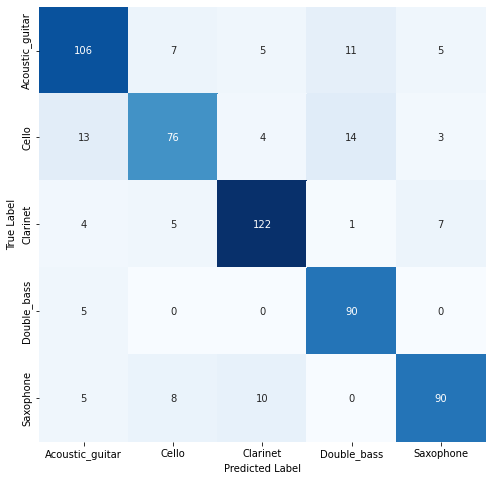

In [ ]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()